In [14]:
import torch
torch.set_num_threads(1)
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

In [15]:
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

#Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [16]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [33]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
def mlpf_loss(y, ypred):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    npart = y["pt"].numel()

    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = 100 * loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = 10 * torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all particles
    loss["Classification"] = loss_classification.sum() / npart
    loss["Regression"] = loss_regression.sum() / npart

    loss["Total"] = loss["Classification"] + loss["Regression"]
    return loss
    
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU()
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act, nn.Linear(width, embedding_dim), self.act
        )

        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        x = self.mul.mul(x, mask.to(x.dtype).unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU  # Change activation function here
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum


model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [34]:
max_events_train = 1000
events_per_batch = 10

losses = []

#Training loop
inds_train = range(0,max_events_train,events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0]!=0

    preds = model(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    loss["Total"].backward()
    optimizer.step()
    current_loss = loss["Total"].detach().item()
    losses.append(current_loss)
    print("Loss={:.2f}".format(loss["Total"].detach().item()))

Loss=146.23
Loss=134.96
Loss=135.68


KeyboardInterrupt: 

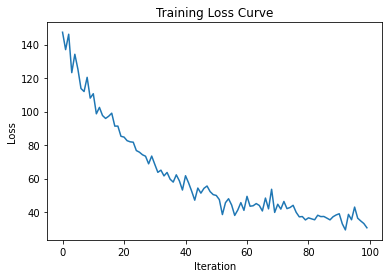

In [26]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

## Quantized model

In [27]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_prepared = torch.ao.quantization.prepare(model)

#calibrate on data
num_events_to_calibrate = 1
for ind in range(1000,1000+num_events_to_calibrate):
    X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    mask = X[:, :, 0]!=0
    model_prepared(X, mask)

model_int8 = torch.ao.quantization.convert(model_prepared)

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


## Training on the quantized model

In [28]:
model_int8

MLPF(
  (nn0_id): Sequential(
    (0): QuantizedLinear(in_features=17, out_features=256, scale=18.83978271484375, zero_point=62, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): QuantizedDropout(p=0.0, inplace=False)
    (4): QuantizedLinear(in_features=256, out_features=256, scale=0.03470222279429436, zero_point=63, qscheme=torch.per_channel_affine)
  )
  (nn0_reg): Sequential(
    (0): QuantizedLinear(in_features=17, out_features=256, scale=18.78470230102539, zero_point=61, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): QuantizedDropout(p=0.0, inplace=False)
    (4): QuantizedLinear(in_features=256, out_features=256, scale=0.03149465471506119, zero_point=66, qscheme=torch.per_channel_affine)
  )
  (conv_id): ModuleList(
    (0): SelfAttentionLayer(
      (act): ReLU()
      (mha): QuantizedMultiheadAttention(
        (ou

In [29]:
import torch

# Define your loss function (mlpf_loss) and optimizer (optimizer) here

# Set the model to evaluation mode
model_int8.eval()

# Define the number of events to process
max_events_calibrate = 1000
events_per_batch = 10

# List to store losses
losses_int8 = []

# Calibration loop
for ind in range(max_events_calibrate, max_events_calibrate + num_events_to_calibrate, events_per_batch):
    # Reset gradients
    optimizer.zero_grad()

    # Prepare input data
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = torch.nn.utils.rnn.pad_sequence(X_features, batch_first=True)
    mask = X_features_padded[:, :, 0] != 0

    # Forward pass through the quantized model
    with torch.no_grad():  # No need to compute gradients during calibration
        preds_int8 = model_int8(X_features_padded, mask)
        preds_unpacked_int8 = unpack_predictions(preds_int8)
        targets_unpacked = unpack_target(y_targets_padded)
        loss_int8 = mlpf_loss(targets_unpacked, preds_unpacked_int8)
        current_loss_int8 = loss_int8["Total"].item()
        losses_int8.append(current_loss_int8)

    # Print the loss for monitoring
    print("Quantized Loss={:.2f}".format(current_loss_int8))


RuntimeError: empty_strided not supported on quantized tensors yet see https://github.com/pytorch/pytorch/issues/74540